In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy.stats as st
import joblib

from scipy.stats import t
from sklearn import datasets
from random import choices
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error, ConfusionMatrixDisplay, accuracy_score

In [2]:
def data():
    
    prot_embeddings_in = 'protein_embeddings_enzymes_non_enzymes.h5'

    # read per-protein embeddings into a dictionary with key: Uniprot id, value: 1024-d embedding
    counter = 0
    prot_embeddings = dict()
    with h5py.File(prot_embeddings_in, 'r') as f:
        for key, embedding in f.items():
            original_id = embedding.attrs['original_id']
            prot_embeddings[original_id] = np.array(embedding)
    return prot_embeddings

enzyme_embeddings = pd.DataFrame.from_dict(data())

In [3]:
annotations = pd.read_csv('Data_set/ec_annotations_single.tab', sep='\t')
annotations['EC number'] = annotations['EC number'].str[:1]
test = pd.read_table('Data_set/test_set.fasta', sep='\n', skiprows=lambda x: (x != 0) and not x % 2 == 0)
head = test.columns
test.loc[-1] = head[0]
test.reset_index(drop=True, inplace=True)
test.rename(columns={head[0]: 'Entry'}, inplace=True)
test['Entry'] = test['Entry'].str[1:]
test_annotated = (((enzyme_embeddings[enzyme_embeddings.columns.intersection(test['Entry'].tolist())]).T).reset_index(level=0)).rename(columns={'index': 'Entry'})
test_annotated['Annotation'] = np.full(600, 0)

In [4]:
X_test = pd.merge(test_annotated, annotations)
enzymeid = np.array(X_test['Entry'])
ec = np.array(X_test['EC number'])
for i in range(len(enzymeid)):
    test_annotated.loc[(test_annotated.Entry == enzymeid[i]), 'Annotation'] = ec[i]
test_annotated.drop(columns=['Entry'], inplace = True) # data with entries and annotations

In [5]:
def pipeline(test_set):
    test_embeddings = test_set.copy()
    enznonenz = joblib.load('non_enzyme')
    enzyme_pred = enznonenz.predict(test_embeddings.drop(columns=['Annotation']))
    test_embeddings['y_pred'] = enzyme_pred
    X_test_pp = (test_embeddings.loc[test_embeddings['y_pred'] == 1]).drop(columns=['y_pred'])
    test_embeddings_nonenz = test_embeddings.loc[test_embeddings['y_pred'] == 0]
    perprotein = joblib.load('final-per-protein')
    perprotein_pred = perprotein.predict(X_test_pp.drop(columns=['Annotation']))
    X_test_pp['y_pred'] = perprotein_pred
    result = X_test_pp.append(test_embeddings_nonenz).sort_index()
    return result

In [6]:
y_test = test_annotated['Annotation'].to_numpy(dtype=int)
y_pred = ((pipeline(test_annotated))['y_pred']).to_numpy(dtype=int)

In [7]:
bootstrapping_acc = []
bootstrapping_mcc = []
bootstrapping_f1 = []
for i in range(1000):
    choice = (pd.DataFrame(choices(test_annotated.to_numpy(), k=600))).rename(columns={1024: "Annotation"})
    y_choice = choice['Annotation'].to_numpy(dtype=int)
    y_pred_rand = (pipeline(choice))['y_pred']
    acc = accuracy_score(y_choice, y_pred_rand)
    mcc = matthews_corrcoef(y_choice, y_pred_rand)
    f1 =  f1_score(y_choice, y_pred_rand, average = 'weighted')
    bootstrapping_acc.append(acc)
    bootstrapping_mcc.append(mcc)
    bootstrapping_f1.append(f1)

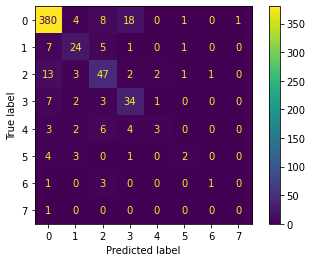

Acc: 0.8183333333333334
F1: 0.8110477469691204
MCC: 0.6357744777132075
SE for Accuracy: 0.015341859585967914
SE for MCC: 0.027857927418034
SE for F1: 0.016321018576565708
CI for Accuracy: 0.030105930638096082
CI for MCC: 0.054666699683233615
CI for F1: 0.03202737259168867


In [8]:
SE_acc = np.std(bootstrapping_acc)
SE_mcc = np.std(bootstrapping_mcc)
SE_f1 = np.std(bootstrapping_f1)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')
mcc = matthews_corrcoef(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7])
disp.plot()
plt.show()
print('Acc:', acc)
print('F1:', f1)
print('MCC:', mcc)
print('SE for Accuracy:', SE_acc)
print('SE for MCC:', SE_mcc)
print('SE for F1:', SE_f1)
print('CI for Accuracy:', np.std(bootstrapping_acc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_acc)))
print('CI for MCC:', np.std(bootstrapping_mcc) * t.ppf((1 + 0.95) / 2, len(bootstrapping_mcc)))
print('CI for F1:', np.std(bootstrapping_f1) * t.ppf((1 + 0.95) / 2, len(bootstrapping_f1)))

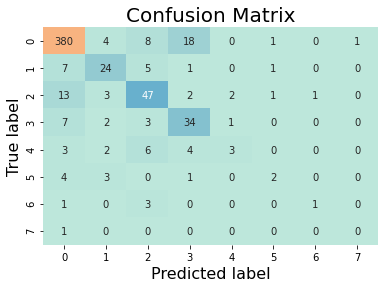

In [9]:
import seaborn as sns

plot = sns.heatmap(cm, annot=True, center=200.0, cbar=False, fmt='g')
plot.set_xticklabels([0,1,2,3,4,5,6,7])
plot.set_yticklabels([0,1,2,3,4,5,6,7])
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plot.set_title('Confusion Matrix', fontsize=20)
fig=plot.get_figure()
fig.savefig('confusion_matrix1.png')